# Extensión de datos sintéticos para ETFs <a class="tocSkip">

Basándome en el [artículo de Sergio Molina publicado en su web Carteras de bolsa](https://carterasdebolsa.com/codigo-python-para-extender-etfs/), que a su vez se basa en un [artículo de TrendXplorer donde usa hojas de Excel](https://indexswingtrader.blogspot.com/2017/03/index-mapping-for-etf-proxies.html), he escrito una función que recibe un diccionario donde las claves son los ETF y los valores los Proxy de cada uno de los ETF, descarga de los servidores de Tiingo (es necesaria clave de la API de Tiingo, que es gratuita) los datos tanto de ETF como de los Proxy (deben usarse los tickers tal como aparecen en Tiingo) y genera los datos sintéticos desde una fecha dada hasta que el ETF tiene datos históricos reales.

Calcula los rendimientos logarítmicos del ETF y del Proxy, para con ellos realizar una regresión lineal con los datos del periodo para el que existen datos. Posteriormente calcula los datos sintéticos del ETF usando esa regresión lineal.

Pero a diferencia de los articulos mencionados, la fúnción añade ademas un residuo al retorno sintético, que se calcula ajustando a los residuos de la regresión lineal una distribución t-student y posteriormente generando una muestra aletoria de dicha distribución.  Esto permite que los datos sintéticos tengan ruido respecto al Proxy, tal como lo tiene los datos reales del ETF.

La función admite varios ETF y Proxy, devolviendo los mismos ETF con los datos extendidos y los reales juntos, como opción puede devolver un dataframe multiindice de Pandas con todos los datos usados para el calculo, por si se quieren verificar o usar de alguna manera.

In [ ]:


# Importamos los paquetes necesarios

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
from tiingo import TiingoClient
import warnings
warnings.filterwarnings("ignore")
   

In [36]:
# Definimos la función que extenderá los ETF


def etf_sim_data(etfs, startDate='2002-01-01', endDate=None, verbose=False,
                 plot=False, key=None, frequency='daily', return_raw=False):

    # Comprueba que se ha pasado un diccionario
    if not isinstance(etfs, dict):
        print('Debe pasar un diccionario con los ETF como claves y los Proxy como valores')
        return

    etf_names = list(etfs.keys())
    tickers = etf_names + list(set(etfs.values()))

    # Comprueba que se ha pasado una key de la API de Tiingo
    if key is None:
        print('Debe indicar su key de Tiingo para descargar los datos')
        return
    else:
        try:
            client = TiingoClient(
                {'api_key': key})
        except:
            print('La key de Tiingo proporcionada no es valida')
            return

    # Descarga los datos desde Tiingo
    quotes = client.get_dataframe(tickers,
                                  metric_name='adjClose',
                                  frequency=frequency,
                                  startDate=startDate,
                                  endDate=endDate)

    re_data = {}
    agg_data = {}

    # Genera los datos sintéticos para cada ETF
    for etf, proxy in etfs.items():

        data = quotes[[etf, proxy]].dropna(how='all')

        # Calcula los rendimientos logarítmicos
        data[['ETF_returns', 'Proxy_returns']] = np.log(data).diff().fillna(0)

        # Toma las fechas necesarias
        fechaInicio = data[etf].first_valid_index()
        fechaFinal = data.last_valid_index()

        # Calcula los parametros de la regresión lineal
        gradient, intercept, r_value, p_value, std_err = stats.linregress(
            data[['Proxy_returns', 'ETF_returns']].loc[fechaInicio:fechaFinal])

        # Si se indica, imprime información sobre la regresión y correlación
        if verbose:
            print(etf)
            print('  Primer dato historico con fecha : {}'.format(fechaInicio))
            print("  Gradiente: {}\n  Intercepto: {}\n  Coeficiente de correlación: {}".format(
                gradient, intercept, r_value))

        # Calcula los residuos de la regresión
        data['errores'] = np.nan
        data['errores'][fechaInicio:] = data['ETF_returns'][fechaInicio:] - (
            data['Proxy_returns'] * gradient + intercept)[fechaInicio:]

        # Ajusta una t-student a los residuos
        params = stats.t.fit(data.errores.dropna())
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
        # Genera una muestra aleatoria de la distribución de los residuos
        sim_error = stats.t.rvs(loc=loc, scale=scale, *arg,
                                size=data['ETF_returns'][:fechaInicio].shape[0])

        # Calcula los datos sinteticos con la regresión lineal mas los residuos simulados
        data['ETF_returns'][:fechaInicio] = ((
            data['Proxy_returns'] * gradient + intercept)[:fechaInicio]) + sim_error
        NameExt = etf + '+'
        data[NameExt] = np.nan
        data[NameExt][:fechaInicio] = (data[etf][fechaInicio] * np.exp(-data['ETF_returns']
                                                                       [:fechaInicio].sort_index(ascending=False, axis=0).cumsum()))[::-1]

        # Grafica si se le indica
        if plot:
            data[[etf, proxy, NameExt]].plot(figsize=(12, 8))

        # Une datos reales y sinteticos en una única serie
        ext_etf = data[etf].mask(data[etf].isna(), data[NameExt])

        re_data[etf] = ext_etf
        agg_data[etf] = data

    # Devuelve los datos solicitados
    if return_raw:
        return pd.concat(re_data, axis=1), pd.concat(agg_data, axis=1)
    else:
        return pd.concat(re_data, axis=1)

Veamos un ejemplo del uso de la función.

SSO
  Primer dato historico con fecha : 2006-06-23 00:00:00
  Gradiente: 1.9867768894078606
  Intercepto: -0.00115904292190649
  Coeficiente de correlación: 0.9982856535817257
RPV
  Primer dato historico con fecha : 2006-03-10 00:00:00
  Gradiente: 1.3088136276900666
  Intercepto: -0.0004150088720500779
  Coeficiente de correlación: 0.9025793237299059
IWM
  Primer dato historico con fecha : 2000-05-26 00:00:00
  Gradiente: 1.008905067342911
  Intercepto: -0.00013755361915953278
  Coeficiente de correlación: 0.9878538184823056
TLT
  Primer dato historico con fecha : 2002-07-26 00:00:00
  Gradiente: 0.7364035040670979
  Intercepto: 0.0005046740723441447
  Coeficiente de correlación: 0.994547920119915
IEI
  Primer dato historico con fecha : 2007-01-12 00:00:00
  Gradiente: 0.7736827770550917
  Intercepto: 0.0001250984965407275
  Coeficiente de correlación: 0.9531435346131382
IEF
  Primer dato historico con fecha : 2002-07-26 00:00:00
  Gradiente: 1.3343647688665945
  Intercepto: -0.000100

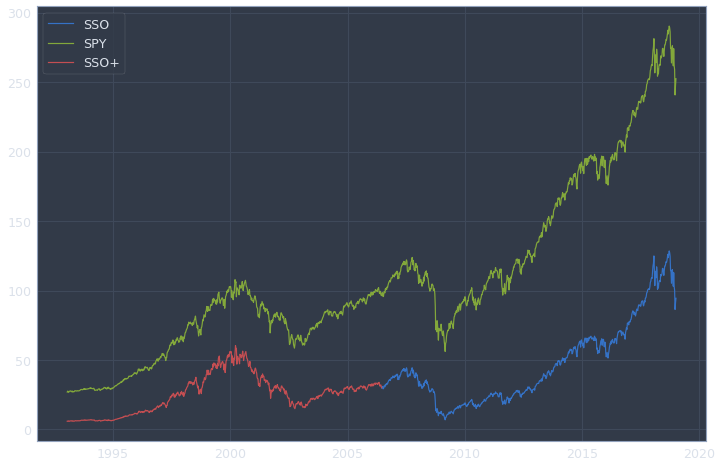

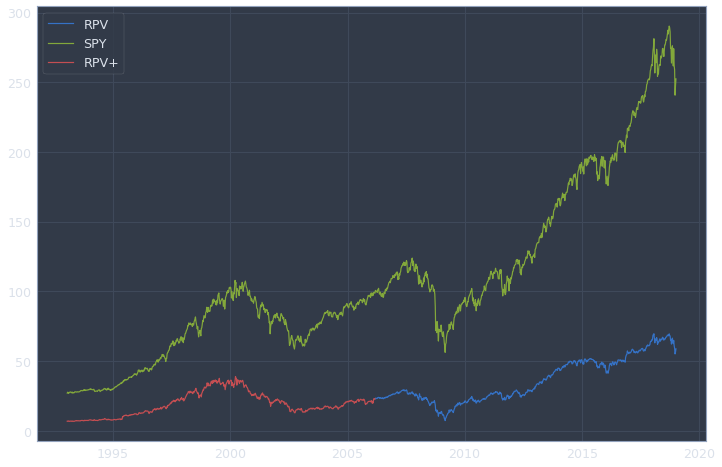

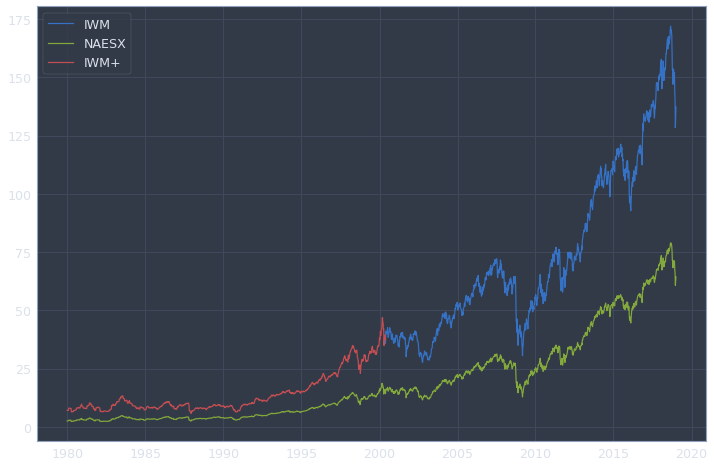

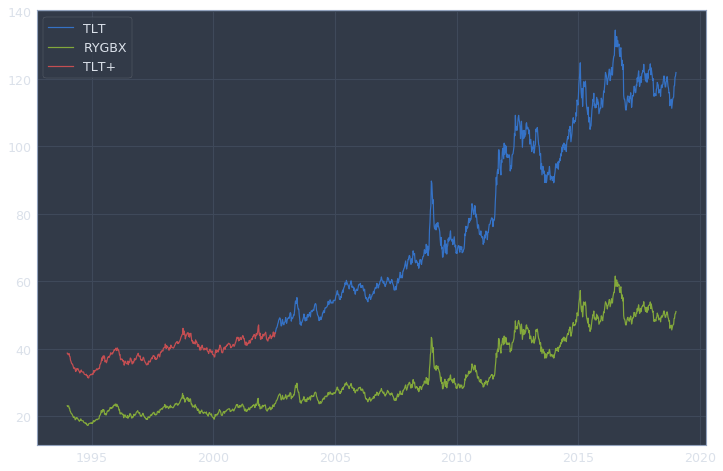

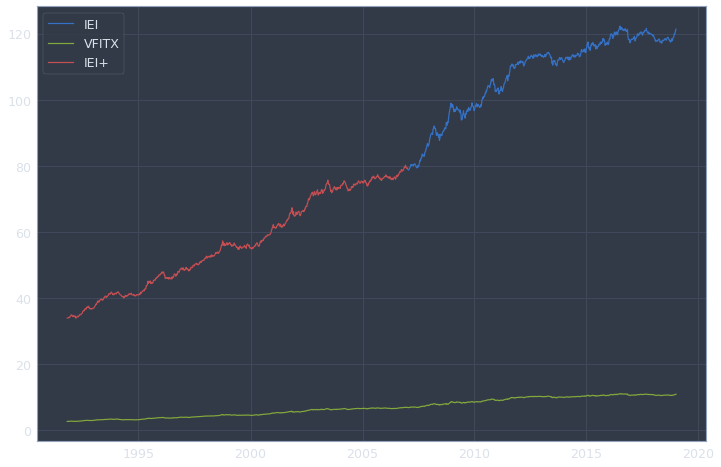

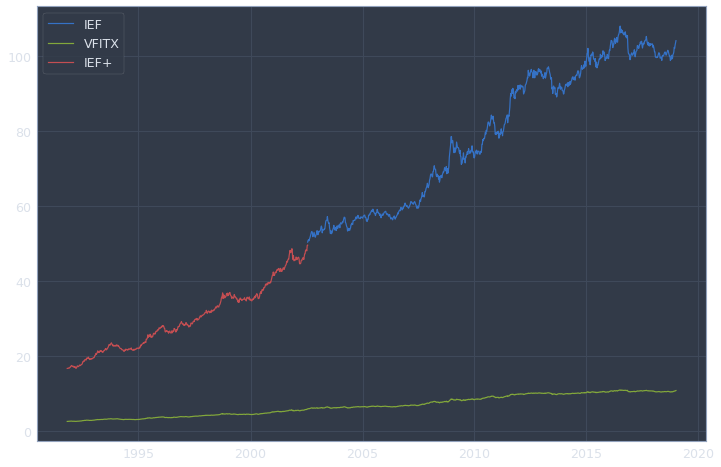

In [37]:
etfs = {'SSO': 'SPY',
        'RPV': 'SPY',
        'IWM': 'NAESX',
        'TLT': 'RYGBX',
        'IEI': 'VFITX',
        'IEF': 'VFITX'}

etf_ext, data = etf_sim_data(etfs, startDate='1969-12-01',
                             endDate='2018-12-31',
                             frequency='weekly',
                             return_raw=True,
                             verbose=True,
                             plot=True,
                             key='aqui-su-key-de-Tiingo')